In [1]:
import os  # ensure we can import the lte_code
import sys
sys.path.append(os.getcwd()+"/..")
sys.path


from lte_code.bandit import Bandit
import jax
import jax.numpy as jnp
ACT_DIM = 10

from lte_code.lte_model3 import LTE
from transformers import DecisionTransformerConfig

## note the 4 here!
config = DecisionTransformerConfig(act_dim=ACT_DIM, state_dim=1)
num_training_steps = 1000*1000

import optax
def warmup_linear_schedule(
    learning_rate: float,
    total_steps: int,
    warmup_ratio: int):
    warmup_steps = int(total_steps*warmup_ratio)
    schedules = [
      optax.linear_schedule(
          init_value=0,
          end_value=learning_rate,
          transition_steps=warmup_steps),
      optax.linear_schedule(
          init_value=learning_rate,
          end_value=0,
          transition_steps= total_steps - warmup_steps),]
    return optax.join_schedules(schedules, [warmup_steps])


schedule = warmup_linear_schedule(learning_rate=1e-5,
                                  total_steps=num_training_steps,
                                  warmup_ratio=0.1)
optimizer = optax.chain(
  optax.clip(0.25),
  optax.adamw(learning_rate=schedule, weight_decay=1e-4),
)

In [2]:
config = DecisionTransformerConfig(act_dim=ACT_DIM, state_dim=ACT_DIM, n_head=4)
model = LTE(config)
key = jax.random.PRNGKey(0)
pkey, key = jax.random.split(key)

# to train first model
new_params = model.init(key)
opt_state = optimizer.init(new_params)
carry = (new_params, opt_state, key)

In [3]:
ENV = Bandit(key=jax.random.PRNGKey(42), n=ACT_DIM,
             deterministic=False,
             noise_scale=0.5)
batch_step = jax.vmap(ENV.step)
batch_mset = jax.vmap(ENV.meta_reset)
BATCH_SIZE = 128

In [4]:
def reward_sequence(states, actions):
    """takes a batch of states
    and a batch of actions [batch_dim, seq_len, act_dim]
    and calculates the rewards, [batch_dim, seq_len, rewards]"""
    def step_state_reward(state, action):
        state = batch_step(state, action)
        return state, state.reward
    states, rewards = jax.lax.scan(step_state_reward,
                                   states,
                                   jnp.swapaxes(actions, 0, 1))
    return jnp.swapaxes(rewards, 0, 1)[..., 0]

def max_in_seq(values):
    """takes a batch of values [batch_dim, seq_len]
    and calculates the the running maximums along the seq_len"""
    def run_max(max_, val):
        max_ = jnp.maximum(max_, val)
        return max_, max_
    return jnp.swapaxes(jax.lax.scan(run_max, -jnp.inf+jnp.zeros(values.shape[0]),
                        jnp.swapaxes(values, 0, 1))[1],
                        0, 1)

def tokenize(actions_batch, rewards_batch):
    @jax.vmap
    @jax.vmap
    def one_hot(act):
        return jnp.zeros(shape=ACT_DIM).at[act].set(1)
    action_tokens = one_hot(actions_batch)
    reward_tokens = jnp.expand_dims(rewards_batch, 2)
    return action_tokens, reward_tokens

In [5]:
import flax
def epsilon_samp(logits, e):
    p = flax.linen.activation.softmax(logits)
    return jnp.log((1-e)*p+e*jnp.ones(logits.shape)/logits.shape[-1])

In [6]:
from functools import partial

@partial(jax.jit, static_argnames=('argmax', 'epsilon', 'greater'))
def exploit(model_params, states, actions, rewards, key,
            running_max, argmax=False, greater=False,
            epsilon=0):
    """Exploiting at each step of the sequence
    return the rewards, and the loss"""    
    action_tokens, reward_tokens = tokenize(actions_batch=actions,
                                            rewards_batch=rewards)
    batch_size, seq_len, act_dim = action_tokens.shape
    action_tokens = jnp.concatenate((jnp.zeros((batch_size, 1, act_dim)),
                                     action_tokens), axis=1)
    reward_tokens = jnp.concatenate((jnp.zeros((batch_size, 1, 1)),
                                     reward_tokens), axis=1)

    time_steps = jnp.zeros((batch_size, seq_len+1), dtype=int).at[:].set(jnp.arange(seq_len+1))
    hidden_state = model.apply(model_params,
                               actions=action_tokens,
                               rewards=reward_tokens,
                               position_ids=time_steps).last_hidden_state
    max_logits = model.pred_max.apply(model_params['pred_max'],
                                      hidden_state)
    nonmax_logits = model.pred_nonmax.apply(model_params['pred_nonmax'],
                                            hidden_state)
    ckey, ukey, rkey = jax.random.split(key, 3)
    if epsilon > 0:
        sample_logits = jax.lax.stop_gradient(epsilon_samp(max_logits, epsilon))
    else:
        sample_logits = jax.lax.stop_gradient(max_logits)
    if not argmax:
        m_actions = jax.random.categorical(logits=sample_logits, key=ckey, axis=-1)
    else:
        m_actions = jnp.argmax(max_logits, axis=-1)

    m_rewards = reward_sequence(states, m_actions)
    running_max = jnp.append((jnp.zeros((batch_size,1))-jnp.inf), running_max, axis=1)
    
    if greater:
        action_preds = jnp.where(jnp.expand_dims(m_rewards > running_max, 2),
                                 max_logits, nonmax_logits)
    else:
        action_preds = jnp.where(jnp.expand_dims(m_rewards >= running_max, 2),
                                 max_logits, nonmax_logits)
    ## important sanity step here stopping the gradients
    loss = optax.softmax_cross_entropy_with_integer_labels(action_preds+sample_logits,
                                                           jax.lax.stop_gradient(m_actions)).mean()
    ## in general, if we are sampling with logits_a
    ## and we are estimating logits_b
    ## then we want softmax(logits_a+logits_b, seen stuff)
    ## so that we calculate P(A|G) \propto P(G|A) given uniform A.
    ## P(a | b) = \frac{p(b|a)p(a)}{p(b)}
    ## we are really calculating P(G | A), and sampling A to maximize that
    return m_rewards, loss

In [7]:
maxi = jax.random.normal(key=key, shape=(10000, ACT_DIM)).max(axis=1).mean()

In [8]:
def run_exploit(model_params,
                states,
                actions,
                key, argmax=True,epsilon=0):
    m_key, a_key, e_key = jax.random.split(key, 3)
    rewards = reward_sequence(states=states,
                              actions=actions)
    running_max = max_in_seq(rewards)
    return exploit(model_params, states, actions, rewards, e_key,
                   running_max,
                   argmax=argmax,
                   epsilon=epsilon)[0]

import matplotlib.pyplot as plt

In [9]:
### Functions for autoregressive sampling

from flax.core.frozen_dict import unfreeze, freeze
def feed_token(model_params, cache,
               actions, rewards, position_ids):
    """takes the parameters, the current model cache,
    the token, token_type, and time_step
    and feeds them to the model updating the cache
    
    Note, can process multiple tokens at once
    token should be [batch_size, seq_len, token_dim]
    and token_type [batch_size, seq_len]
    time_step [batch_size, seq_len]"""
    ra = unfreeze(model_params)
    ra['seq']['cache'] = cache['cache']
    return model.apply(params=ra, mutable=['cache'],
                       actions=actions,
                       rewards=rewards,
                       position_ids=position_ids)

SEQ_LEN = 100

from functools import partial
@partial(jax.jit, static_argnames="batch_size")
def init_cache(model_params, batch_size):
    return model.apply(
        params=model_params,
        init_cache=True,
        mutable=['cache'],
        actions=jnp.zeros((batch_size, SEQ_LEN, ACT_DIM)),
        rewards=jnp.zeros((batch_size, SEQ_LEN, 1)),
        position_ids=jnp.zeros((batch_size, SEQ_LEN), dtype=int),
    )[1]

batch_size = 128
CACHE = freeze(init_cache(new_params, batch_size))

In [10]:
@partial(jax.jit, static_argnames=("batch_size", "argmax", "pred_f1", "pred_f2", "pred_f3"))
def autoregressive_rollout(model_params, key, batch_size, state,
                           pred_f1, pred_f2, pred_f3, argmax=False,
                           seq_len=SEQ_LEN):
    """function to do a rollout given a policy
    
    model_params specifies the model parameters
    key is the jax.random.PRNGKey to seed the rng
    batch_size is batch_size
    state is the initial environment state
    and pred_f is the function that maps 
    the model hidden state to action probabilities
    argmax is whether to select the most probable action
    or to sample
    and epsilon is the probability of random action selection"""
    cache = init_cache(model_params, batch_size)
    act_token = jnp.zeros((batch_size, 1, ACT_DIM))
    reward_token = jnp.zeros((batch_size, 1, 1))
    time_step = jnp.zeros((batch_size, 1))
    m_key, a_key, a2_key = jax.random.split(key, 3)
    cache = init_cache(model_params, batch_size)
    carry = act_token, reward_token, time_step, cache, state

    def one_step(carry, key):
        act_token, reward_token, time_step, cache, state = carry
        ans, cache = feed_token(model_params=model_params,
                                cache=cache,
                                actions=act_token,
                                rewards=reward_token, 
                                position_ids=time_step)
        hidden_state = ans.last_hidden_state
        # batch_size, seq_len, act_dim
        logits = pred_f1(hidden_state[:, -1, ...])
        logits_2 = pred_f2(hidden_state[:, -1, ...])
        logits_3 = pred_f3(hidden_state[:, -1, ...])
        ckey, ukey, rkey = jax.random.split(key, 3)
        if not argmax:
            actions = jax.random.categorical(logits=logits,
                                             key=ckey, axis=-1)
        else:
            actions = jnp.argmax(logits, axis=-1)
        state = batch_step(state, actions)
        
        @jax.vmap
        def one_hot(act):
            return jnp.zeros(shape=ACT_DIM).at[act].set(1)
        act_token = jnp.expand_dims(one_hot(actions), 1)
        reward_token = jnp.expand_dims(state.reward, 1)
        time_step = time_step+1
        return ((act_token, reward_token, time_step, cache, state),
                (actions, state.reward[:, 0], logits, logits_2, logits_3))
    carry, x = one_step(carry, a_key)
    _, xs = jax.lax.scan(one_step, carry, 
                         jax.random.split(a2_key, seq_len-1))
    xs = jax.tree_map(lambda a, b :jnp.swapaxes(jnp.append(jnp.expand_dims(a, 0),
                                                                         b, axis=0),
                                                              0, 1), 
                                    x, xs)
    return xs

In [11]:
def explore(model_loit_params,
            model_lore_params,
            states, batch_size, key, e_epsilon=0, m_epsilon=0,
           e_argmax=False, m_argmax=False):
    """explores autoregressively from the states
    and calcualtes the exploit and explore loss"""
    
    rollout_key, exploit_key = jax.random.split(key, 2)
    ### generate the explore sequence
    
#     @jax.jit
    def predf1(hidden_state): 
        logits = model.pred_exp.apply(model_lore_params['pred_exp'],
                                              hidden_state)
        logits = jax.lax.stop_gradient(epsilon_samp(logits, e_epsilon))
        return logits
    
#     @jax.jit
    def predf2(hidden_state): 
        logits = model.pred_nonexp.apply(model_lore_params['pred_exp'],
                                         hidden_state)
        return logits
    
    def predf3(hidden_state): 
        logits = model.pred_nonexp.apply(model_lore_params['pred_nonexp'],
                                         hidden_state)
        return logits

    actions, rewards, sample_logits, logits2, logits3 =\
    autoregressive_rollout(model_params=model_lore_params,
                           key=rollout_key,
                           batch_size=batch_size,
                           state=states,
                           pred_f1=predf1,
                           pred_f2=predf2,
                           pred_f3=predf3,
                           argmax=e_argmax)
    running_max = max_in_seq(rewards)
    loit_rewards, loit_loss =\
    exploit(model_params=model_loit_params,
            states=states,
            actions=actions,
            rewards=rewards,
            key=exploit_key,
            running_max=running_max,
            argmax=m_argmax,
            epsilon=m_epsilon)
    explore_cond = loit_rewards[:, 1:] > jnp.pad(running_max[:, :-1],
                                                 ((0, 0), (1,0)),
                                                 constant_values=-jnp.inf)
    action_preds = jnp.where(jnp.expand_dims(explore_cond, 2),
                             logits2, logits3)
    lore_loss = optax.softmax_cross_entropy_with_integer_labels(\
    action_preds+sample_logits, jax.lax.stop_gradient(actions)).mean()
    return loit_rewards, loit_loss, lore_loss # exploit rewards, exploit loss, explore loss

In [12]:
def explore__exploit_rewards(loit_params, lore_params, key, batch_size, e_argmax, m_argmax):
    m_key, e_key = jax.random.split(key, 2)
    states = batch_mset(jax.random.split(m_key, batch_size))
    rewards, loit_loss, lore_loss = explore(loit_params,
                                            lore_params,
                                           states,
                                           batch_size,
                                           key=e_key,
                                           e_epsilon=0,
                                           m_epsilon=0,
                                           e_argmax=e_argmax,
                                           m_argmax=m_argmax)
    return rewards

In [13]:
# plt.savefig(save_name, bbox_inches='tight')
import pickle
first_explore_runs = []
for n in range(4, 14):
    with open(f"../bandit_runs/n10_p100_b128_normal_nexpFalse_seed{n}/run_data.pkl", "rb") as file:
        data = pickle.load(file)
        first_explore_runs.append(data[0][0])
        
always_exploit_runs = []
for n in range(4, 14):
    with open(f"../bandit_always-exploit_runs/n10_p100_b128_normal_nexpFalse_seed{n}/run_data.pkl", "rb") as file:
        data = pickle.load(file)
        always_exploit_runs.append(data[0][0])

In [14]:
def pure_explore_rollout(model_lore_params,
                         key, batch_size,
                         argmax=True, e_epsilon=0):

    """does auto-regressive exploration (should be used with the first-explore trained model)"""
    
    e_epsilon = 0
    m_key, e_key = jax.random.split(key, 2)
    states = batch_mset(jax.random.split(m_key, batch_size))
    rollout_key, exploit_key = jax.random.split(e_key, 2)
    ### generate the explore sequence
    
#     @jax.jit
    def predf1(hidden_state): 
        logits = model.pred_exp.apply(model_lore_params['pred_exp'],
                                              hidden_state)
        logits = jax.lax.stop_gradient(epsilon_samp(logits, e_epsilon))
        return logits
    
#     @jax.jit
    def predf2(hidden_state): 
        logits = model.pred_nonexp.apply(model_lore_params['pred_exp'],
                                         hidden_state)
        return logits
    
    def predf3(hidden_state): 
        logits = model.pred_nonexp.apply(model_lore_params['pred_nonexp'],
                                         hidden_state)
        return logits

    actions, rewards, sample_logits, logits2, logits3 =\
    autoregressive_rollout(model_params=model_lore_params,
                           key=rollout_key,
                           batch_size=batch_size,
                           state=states,
                           pred_f1=predf1,
                           pred_f2=predf2,
                           pred_f3=predf3,
                           argmax=argmax)
    return actions, rewards

In [15]:
def pure_exploit_rollout(model_lore_params,
                         key, batch_size,
                         argmax=True, e_epsilon=0):

    """does auto-regressive exploitation (should be used with the always-exploit trained model)"""
    
    e_epsilon = 0
    m_key, e_key = jax.random.split(key, 2)
    states = batch_mset(jax.random.split(m_key, batch_size))
    rollout_key, exploit_key = jax.random.split(e_key, 2)
    ### generate the explore sequence
    
#     @jax.jit
    def predf1(hidden_state): 
        logits = model.pred_exp.apply(model_lore_params['pred_max'],
                                              hidden_state)
        logits = jax.lax.stop_gradient(epsilon_samp(logits, e_epsilon))
        return logits
    
#     @jax.jit
    def predf2(hidden_state): 
        logits = model.pred_nonexp.apply(model_lore_params['pred_max'],
                                         hidden_state)
        return logits
    
    def predf3(hidden_state): 
        logits = model.pred_nonexp.apply(model_lore_params['pred_nonmax'],
                                         hidden_state)
        return logits

    actions, rewards, sample_logits, logits2, logits3 =\
    autoregressive_rollout(model_params=model_lore_params,
                           key=rollout_key,
                           batch_size=batch_size,
                           state=states,
                           pred_f1=predf1,
                           pred_f2=predf2,
                           pred_f3=predf3,
                           argmax=argmax)
    return actions, rewards

In [16]:
import jax.numpy as jp
import jax

@jax.vmap
def run_unique(arr):
    rets = []
    n = 0
    for i in range(len(arr)):
        n+= ~jp.isin(arr[i], arr[:i])
        rets.append(n)
    return jp.array(rets)

In [17]:
@partial(jax.jit, static_argnames=("batch_size", "argmax"))
def autoregressive_explore_acts(lore_params, key, batch_size, bstate, argmax):
    def predf1(hidden_state): 
        logits = model.pred_exp.apply(lore_params['pred_exp'],
                                              hidden_state)
        return logits
   
    def predf2(hidden_state): 
        logits = model.pred_nonexp.apply(lore_params['pred_exp'],
                                         hidden_state)
        return logits
    
    def predf3(hidden_state): 
        logits = model.pred_nonexp.apply(lore_params['pred_nonexp'],
                                         hidden_state)
        return logits
    return autoregressive_rollout(lore_params, key, batch_size, bstate,
                                  predf1, predf2, predf3, argmax=argmax)[0]


def e_logit(logit, e):
    return jnp.log(jax.nn.softmax(logit)*(1-e)+e*jnp.ones(logit.shape)/logit.shape[-1])

@partial(jax.jit, static_argnames=("batch_size", "argmax"))
def autoregressive_exploit_acts(lore_params, key, batch_size, bstate, argmax, epsilon=0.1, t=1):
    def predf1(hidden_state): 
        logits = model.pred_exp.apply(lore_params['pred_max'],
                                              hidden_state)
        return e_logit(t*logits, epsilon)
   
    def predf2(hidden_state): 
        logits = model.pred_nonexp.apply(lore_params['pred_exp'],
                                         hidden_state)
        return logits
    
    def predf3(hidden_state): 
        logits = model.pred_nonexp.apply(lore_params['pred_nonexp'],
                                         hidden_state)
        return logits
    return autoregressive_rollout(lore_params, key, batch_size, bstate,
                                  predf1, predf2, predf3, argmax=argmax)[0]


@partial(jax.jit, static_argnames=('argmax', 'epsilon'))
def exploit_acts_and_rewards(model_params, states, actions, rewards, key, argmax=False,
                 epsilon=0):
    """Exploiting at each step of the sequence
    return the rewards, and the loss"""    
    action_tokens, reward_tokens = tokenize(actions_batch=actions,
                                            rewards_batch=rewards)
    batch_size, seq_len, act_dim = action_tokens.shape
    action_tokens = jnp.concatenate((jnp.zeros((batch_size, 1, act_dim)),
                                     action_tokens), axis=1)
    reward_tokens = jnp.concatenate((jnp.zeros((batch_size, 1, 1)),
                                     reward_tokens), axis=1)

    time_steps = jnp.zeros((batch_size, seq_len+1), dtype=int).at[:].set(jnp.arange(seq_len+1))
    hidden_state = model.apply(model_params,
                               actions=action_tokens,
                               rewards=reward_tokens,
                               position_ids=time_steps).last_hidden_state
    max_logits = model.pred_max.apply(model_params['pred_max'],
                                      hidden_state)
    nonmax_logits = model.pred_nonmax.apply(model_params['pred_nonmax'],
                                            hidden_state)
    ckey, ukey, rkey = jax.random.split(key, 3)
    if epsilon > 0:
        sample_logits = jax.lax.stop_gradient(epsilon_samp(max_logits, epsilon))
    else:
        sample_logits = jax.lax.stop_gradient(max_logits)
    if not argmax:
        m_actions = jax.random.categorical(logits=sample_logits, key=ckey, axis=-1)
    else:
        m_actions = jnp.argmax(max_logits, axis=-1)

    m_rewards = reward_sequence(states, m_actions)
    return m_actions, m_rewards

## Generate reward plot

In [23]:
import jax.random as jr

In [28]:
batch_size = 10000
first_explore_models = first_explore_runs
always_exploit_models = always_exploit_runs


first_explore_exploit_r = []
for m in range(10):
    print(m, end=';')
    for n in range(10):
        reward = explore__exploit_rewards(first_explore_models[n],
                                          first_explore_models[n],
                                          jax.random.split(key, 10)[m],
                                          batch_size,
                                          e_argmax=True, m_argmax=True)
        first_explore_exploit_r.append(reward.mean(axis=0))
first_explore_exploit_r = jp.array(first_explore_exploit_r)

# calculate first-explore explore rewards
first_explore_explore_r = []
for m in range(10):
    print(m, end=';')
    for n in range(10):
        actions, reward = pure_explore_rollout(first_explore_models[n],
                                               jax.random.split(key, 10)[m],
                                               batch_size, argmax=True)
        first_explore_explore_r.append(reward.mean(axis=0))
first_explore_explore_r = jp.array(first_explore_explore_r)

# calculate always exploit rewards
always_exploit_r = []
for m in range(10):
    print(m, end=';')
    for n in range(10):
        actions, reward = pure_exploit_rollout(always_exploit_models[n],
                                               jax.random.split(key, 10)[m],
                                               batch_size, argmax=True)
        always_exploit_r.append(reward.mean(axis=0))
always_exploit_r = jp.array(always_exploit_r)

# calculate random play rewards
random_play_r = []
keys = jax.random.split(key, 100)
for n in range(100):
    print(n, end=';')
    random_acts = jax.random.randint(minval=0, maxval=10, key=keys[n], shape=(batch_size, 100))
    bstate = batch_mset(jr.split(jr.fold_in(keys[n], 1), batch_size))
    random_play_r.append(reward_sequence(bstate, random_acts).mean(axis=0))
random_play_r = jp.array(random_play_r)

0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;60;61;62;63;64;65;66;67;68;69;70;71;72;73;74;75;76;77;78;79;80;81;82;83;84;85;86;87;88;89;90;91;92;93;94;95;96;97;98;99;

In [40]:
# import pickle
# with open("temp_means.pkl", 'wb') as file:
#     pickle.dump((first_explore_exploit_r,
#                  first_explore_explore_r,
#                  always_exploit_r,
#                  random_play_r), file)

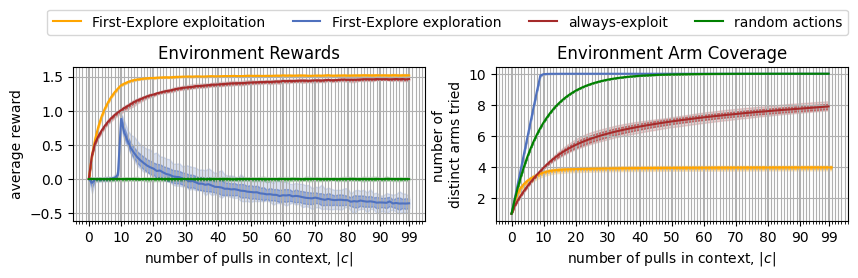

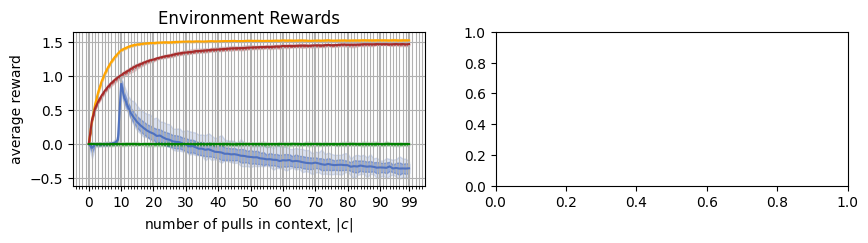

In [96]:
fig, axs = plt.subplots(1, 2, figsize=(10,2))
ax = axs[0]
from matplotlib.ticker import MultipleLocator
def plot_min_max_mean(ax, vals, color, label, style="solid"):
    ax.fill_between(jp.arange(len(vals[0])), jp.min(vals, axis=0),
                 jp.max(vals, axis=0),
                 color=color, alpha=0.2)
    std = jp.std(vals, axis=0)
    ax.fill_between(jp.arange(len(vals[0])),
                    jp.mean(vals, axis=0)-std,
                    jp.mean(vals, axis=0)+std,
             color=color, alpha=0.5)
    ax.plot(jp.arange(len(vals[0])), jp.mean(vals, axis=0),
             label=label,
             color=color,
             linestyle=style)
plot_min_max_mean(ax, first_explore_exploit_r[:, :-1],
                  label="First-Explore exploitation",
                  color="orange")
plot_min_max_mean(ax, first_explore_explore_r,
                  label="First-Explore exploration",
                  color="#4F71BE")
plot_min_max_mean(ax, always_exploit_r,
                  label="always-exploit",
                  color="brown")
plot_min_max_mean(ax, random_play_r,
                  label="random actions",
                  color="green")
ax.set_title("Environment Rewards")
ax.set_xlabel("number of pulls in context, $|c|$")
ax.set_ylabel("average reward")
# ax.legend(title="Policy")
ax.set_xticks(jnp.arange(0, SEQ_LEN+1, ACT_DIM).at[-1].set(99))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which='minor')
ax.grid(which='major', axis='x', linewidth=1.5)
ax.grid(which='major', axis='y')

## Generate coverage plot

In [31]:
@jax.jit
def hand_exploit(states, actions):
    """handcoded exploit function, takes the action with the highest observed value
    provided that is greater than 0 else an untried action"""
    rewards = reward_sequence(states, actions)
    act_counts = jp.array([jax.vmap(jp.cumsum)(\
            actions==a) for a in range(10)])
    rewards = jp.array([jax.vmap(jp.cumsum)(\
            (actions==a)*rewards) for a in range(10)])
    # expected reward of untried arm is 0
    average_value_of_action = jp.nan_to_num(rewards/act_counts, 0)
    hand_actions = jp.argmax(average_value_of_action, axis=0)
    hand_actions = jp.concatenate((jp.zeros((hand_actions.shape[0], 1), dtype=int),
                                   hand_actions), axis=-1)
    exploit_r = reward_sequence(states, hand_actions)
    return hand_actions, exploit_r

In [66]:
batch_size=10000
# calculate actions

first_explore__explore_coverage = []
first_explore__exploit_coverage = []
first_explore_explore__learnt_exploit_reward = []
first_explore_explore__coded_exploit_reward = []

for m in range(10):
    print(m, end=';')
    for n in range(10):
        bstate = batch_mset(jax.random.split(jr.split(key, 10)[m],
                                             batch_size))
        explore_acts = autoregressive_explore_acts(first_explore_models[n],
                                                   jr.fold_in(jr.split(key, 10)[m], 1),
                                                   batch_size, bstate, argmax=True)
        explore_rewards = reward_sequence(bstate, explore_acts)
        exploit_acts, exploit_rewards = exploit_acts_and_rewards(first_explore_models[n],
                                                                 bstate, explore_acts,
                                                                 explore_rewards,
                                                                 jr.fold_in(jr.split(key, 10)[m], 2),
                                                                 argmax=True)
        first_explore__explore_coverage.append(run_unique(explore_acts).mean(axis=0))
        first_explore__exploit_coverage.append(run_unique(exploit_acts).mean(axis=0))
        first_explore_explore__learnt_exploit_reward.append(exploit_rewards.mean(axis=0))
        first_explore_explore__coded_exploit_reward.append(hand_exploit(bstate,
                                                                        explore_acts)[1].mean(axis=0))
first_explore__explore_coverage = jp.array(first_explore__explore_coverage)
first_explore__exploit_coverage = jp.array(first_explore__exploit_coverage)
first_explore_explore__learnt_exploit_reward = jp.array(first_explore_explore__learnt_exploit_reward)
first_explore_explore__coded_exploit_reward = jp.array(first_explore_explore__coded_exploit_reward)


always_exploit__coverage = []
always_exploit__coded_exploit_reward = []

for m in range(10):
    print(m, end=';')
    for n in range(10):
        bstate = batch_mset(jax.random.split(jr.split(key, 10)[m],
                                             batch_size))
        acts = autoregressive_exploit_acts(always_exploit_models[n],
                                           jr.fold_in(jr.split(key, 10)[m], 1),
                                           batch_size, bstate, argmax=True)
        always_exploit__coverage.append(run_unique(acts).mean(axis=0))
        always_exploit__coded_exploit_reward.append(hand_exploit(bstate, acts)[1].mean(axis=0))
        
        
always_exploit__coverage = jp.array(always_exploit__coverage)
always_exploit__coded_exploit_reward = jp.array(always_exploit__coded_exploit_reward)

keys = jax.random.split(key, 100)
random__acts = jax.random.randint(minval=0, maxval=10, key=keys[n], shape=(100, batch_size, 100))
random__coverage = jax.vmap(run_unique)(random__acts).mean(axis=1)

0;1;2;3;4;5;6;7;8;9;

In [75]:
# # import pickle
# with open("temp_coverage.pkl", 'wb') as file:
#     pickle.dump((first_explore__exploit_coverage,
#                  first_explore__explore_coverage,
#                  always_exploit__coverage,
#                  random__coverage,
#                  first_explore_explore__learnt_exploit_reward,
#                  first_explore_explore__coded_exploit_reward,
#                  always_exploit__coded_exploit_reward),
#                 file)

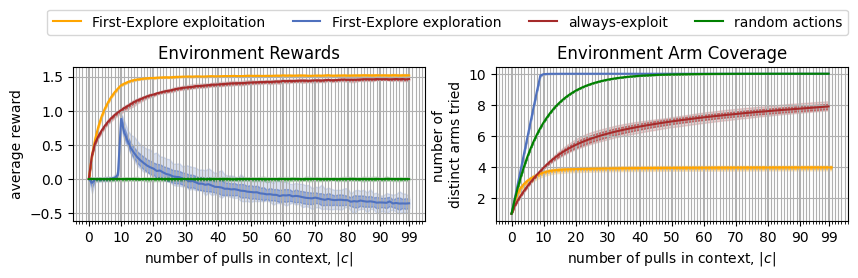

In [97]:
ax = axs[1]
plot_min_max_mean(ax, first_explore__exploit_coverage,
                  label="FE exploitation",
                  color="orange")
plot_min_max_mean(ax, first_explore__explore_coverage,
                  label="FE exploration",
                  color="#4F71BE")
plot_min_max_mean(ax, always_exploit__coverage,
                  label="always-exploit",
                  color="brown")
plot_min_max_mean(ax, random__coverage,
                  label="random actions",
                  color="green")
ax.set_title("Environment Arm Coverage")
ax.set_xlabel("number of pulls in context, $|c|$")
ax.set_ylabel("number of \ndistinct arms tried")
# ax.legend(title="Policy")
ax.set_xticks(jnp.arange(0, SEQ_LEN+1, ACT_DIM).at[-1].set(99))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which='minor')
ax.grid(which='major', axis='x', linewidth=1.5)
ax.grid(which='major', axis='y')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[0:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.2))
fig

In [98]:
plt.figure(fig)
plt.savefig("bandit_plot_1.svg", format='svg', bbox_inches='tight')

## Generate exploration analysis plot

In [63]:
exhaustive_acts = jnp.repeat(jnp.expand_dims(jnp.repeat(jnp.expand_dims(jnp.arange(10), 1),
                                                   11, axis=1).T.reshape(-1)[:100],
                                        0),
                        batch_size, axis=0)

exhaustive__coded_exploit_reward = []
for m in range(10):
    print(m, end=';')
    for n in range(10):  # look ma, no n
        bstate = batch_mset(jax.random.split(jr.split(key, 10)[m],
                                             batch_size))
        acts, reward = hand_exploit(bstate, exhaustive_acts)
        exhaustive__coded_exploit_reward.append(reward.mean(axis=0))
exhaustive__coded_exploit_reward = jp.array(exhaustive__coded_exploit_reward)


random__coded_exploit_reward = []
for m in range(10):
    print(m, end=';')
    for n in range(10):
        bstate = batch_mset(jax.random.split(jr.split(key, 10)[m],
                                             batch_size))
        acts, reward = hand_exploit(bstate, random__acts[10*n+m])
        random__coded_exploit_reward.append(reward.mean(axis=0))
random__coded_exploit_reward = jp.array(random__coded_exploit_reward)

0;1;2;3;4;5;6;7;8;9;0;1;2;3;4;5;6;7;8;9;

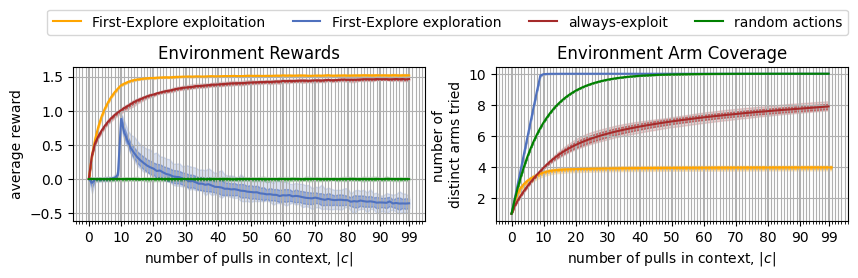

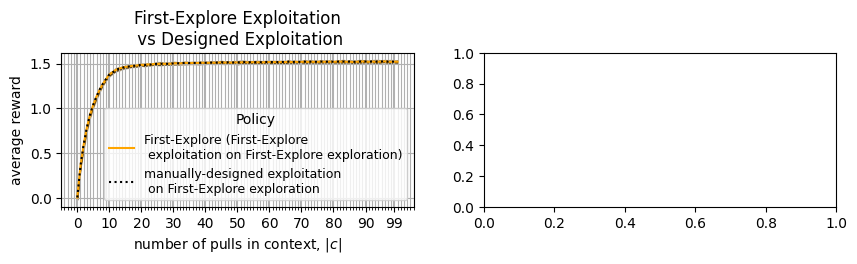

In [99]:
fig, axs = plt.subplots(1, 2, figsize=(10,2))
ax = axs[0]
plot_min_max_mean(ax, first_explore_explore__learnt_exploit_reward,
                  label="First-Explore (First-Explore \n exploitation on First-Explore exploration)",
                  color="orange")
plot_min_max_mean(ax, first_explore_explore__coded_exploit_reward,
                  label="manually-designed exploitation\n on First-Explore exploration",
                  color="black", style="dotted")

ax.set_title("First-Explore Exploitation\n vs Designed Exploitation")
ax.set_xlabel("number of pulls in context, $|c|$")
ax.set_ylabel("average reward")
ax.legend(title="Policy", fontsize=9)
ax.set_xticks(jnp.arange(0, SEQ_LEN+1, ACT_DIM).at[-1].set(99))
ax.xaxis.set_minor_locator(MultipleLocator(1))
# ax.set_ylim(1.2, 1.55)
# ax.set_xlim(0, 30)
ax.grid(which='minor')
ax.grid(which='major', axis='x', linewidth=1.5)
ax.grid(which='major', axis='y')

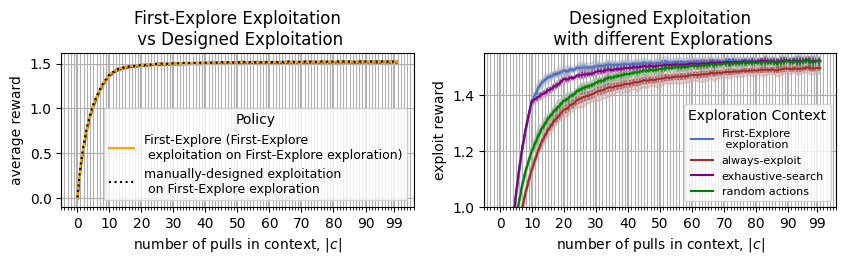

In [100]:
ax = axs[1]
plot_min_max_mean(ax, first_explore_explore__coded_exploit_reward,
                  label="First-Explore\n exploration",
                  color="#4F71BE")
plot_min_max_mean(ax, always_exploit__coded_exploit_reward,
                  label="always-exploit",
                  color="brown")
plot_min_max_mean(ax, exhaustive__coded_exploit_reward,
                  label="exhaustive-search",
                  color="purple")
plot_min_max_mean(ax, random__coded_exploit_reward,
                  label="random actions",
                  color="green")

ax.set_title("Designed Exploitation\n with different Explorations")
ax.set_xlabel("number of pulls in context, $|c|$")
ax.set_ylabel("exploit reward")
ax.legend(title="Exploration Context", fontsize=8)
ax.set_xticks(jnp.arange(0, SEQ_LEN+1, ACT_DIM).at[-1].set(99))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylim(1, 1.55)
# ax.set_xlim(0, 30)
ax.grid(which='minor')
ax.grid(which='major', axis='x', linewidth=1.5)
ax.grid(which='major', axis='y')
fig

In [101]:
plt.figure(fig)
plt.savefig("bandit_plot_2.svg", format='svg', bbox_inches='tight')